# iCAT world
---

#### Overview
Notebook to create stacks of tile specifications in "real-world" or "physical" coordinate space (aka microns). This is to facilitate `5_iCAT-correlate.ipynb` as there is otherwise no way of knowing _a priori_ which high-mag EM tiles overlap with each low-mag EM tile.

#### Packages

In [3]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import renderapi
import icatapi

#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Set up environment
---

In [4]:
# `render` project parameters
# ---------------------------
owner = 'rlane'
project = 'ratpancreas_partial'

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'rlane',
 'project': 'ratpancreas_partial',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

In [5]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]

# Output
# ------
out = f"""\
all stacks.......... {stacks}
EM stacks........... {stacks_EM}
FM stacks........... {stacks_FM}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
stacks = ['EM_lomag', 'EM_himag']
df_project = icatapi.create_stacks_DataFrame(stacks=stacks,
                                             render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))

all stacks.......... ['EM_lomag_overlaid', 'exc_555nm_overlaid', 'exc_405nm_overlaid', 'EM_himag_aligned', 'EM_himag_aligned_fine', 'EM_himag_aligned_rough', 'EM_himag_dsmontages_aligned', 'EM_himag_dsmontages', 'EM_himag_stitched', 'EM_himag_montaged', 'exc_555nm', 'exc_405nm', 'EM_lomag', 'EM_himag']
EM stacks........... ['EM_lomag_overlaid', 'EM_himag_aligned', 'EM_himag_aligned_fine', 'EM_himag_aligned_rough', 'EM_himag_dsmontages_aligned', 'EM_himag_dsmontages', 'EM_himag_stitched', 'EM_himag_montaged', 'EM_lomag', 'EM_himag']
FM stacks........... ['exc_555nm_overlaid', 'exc_405nm_overlaid', 'exc_555nm', 'exc_405nm']
...



tileId    z   width  height   minint   maxint  \
stack                                                                
EM_himag 12  aai_EM_hima...  0.0  4096.0  4096.0  31540.0  35118.0   
         4   aaa_EM_hima...  0.0  4096.0  4096.0  31540.0  35118.0   
         9   aaf_EM_hima...  0.0  4096.0  4096.0  31540.0  35118.0   
EM_lomag 2   aaa_EM_loma...  2.0  4096.0  4096.0  31916.0  33768.0   
         0   aaa_EM_loma...  0.0  4096.0  4096.0  31841.0  33740.0   
         1   aaa_EM_loma...  1.0  4096.0  4096.0  31843.0  33776.0   

               imagePyramid          tforms     stack sectionId  imageRow  \
stack                                                                       
EM_himag 12  [0, 1, 2, 3...  [M=[[1.0000...  EM_himag      S004         5   
         4   [0, 1, 2, 3...  [M=[[1.0000...  EM_himag      S004         6   
         9   [0, 1, 2, 3...  [M=[[1.0000...  EM_himag      S004         5   
EM_lomag 2   [0, 1, 2, 3...  [M=[[1.0000...  EM_lomag      S006         1   
         0   [0, 1, 2, 3...  [M=[[1.0000...  EM_lomag      S004         1   
         1   [0, 1, 2, 3...  [M=[[1.0000...  EM_lomag      S005         1   

             imageCol    stageX    stageY  
stack                                      
EM_himag 12         5  1061.681  6353.054  
         4          6  1078.477  6335.559  
         9          2  1009.028  6353.052  
EM_lomag 2          1  2226.245  6381.133  
         0          1  1021.110  6371.003  
         1          1  1621.125  6381.079

## Create world stacks
---

In [7]:
from matplotlib.transforms import Affine2D as AffineMPL
from renderapi.transform import AffineModel as AffineRender

from icatapi.overlay import get_transform_metadata

In [16]:
channel_map = {
    'EM_lomag': 'Secondary electrons',
    'EM_himag': 'Secondary electrons'
}

# Loop through stacks
for stack, df_stack in tqdm(df_project.groupby('stack')):

    # Loop through tiles
    for i, tile in df_stack.iterrows():

        # Get transform metadata
        fp = Path(tile['imagePyramid'][0].imageUrl.split('.nl')[1])
        tform_md = get_transform_metadata(fp)
        channel_name = channel_map[stack]
        pixelsize, rotation, shear, translation = tform_md[channel_name]

        # Convert from metres to microns
        pixelsize = [1e6*ps for ps in pixelsize]      # m --> um
        translation = [1e6*tr for tr in translation]  # m --> um

        # Create transform
        w = tile['width']
        h = tile['height']
        T = AffineMPL().translate(-w/2, -h/2)\
                       .scale(*pixelsize)\
                       .rotate(rotation)\
                       .skew(shear, 0)\
                       .translate( translation[0],
                                  -translation[1])
        A = AffineRender()
        A.M = T.get_matrix()

        # Replace transform in DataFrame
        df_stack.at[i, 'tforms'] = [A]

    # Create world stack
    stack_world = f"{stack}_world"
    icatapi.upload_stack_DataFrame(df=df_stack,
                                   name=stack_world,
                                   render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

Creating tile specifications for EM_himag_world...
Importing tile specifications to EM_himag_world...
Stack EM_himag_world created successfully.
Creating tile specifications for EM_lomag_world...
Importing tile specifications to EM_lomag_world...
Stack EM_lomag_world created successfully.


## Inspect stacks
---

In [17]:
from icatapi.plotting import plot_tile_map, plot_stacks

### Map out tiles in `render` space

  0%|          | 0/4 [00:00<?, ?it/s]

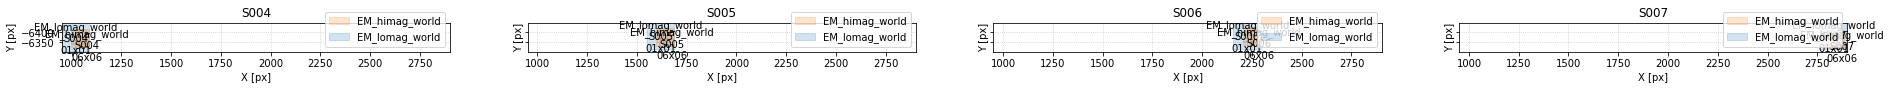

In [19]:
# Set stacks to plot
stacks_2_plot = [stack for stack in stacks if 'world' in stack]

# Plot tile map
plot_tile_map(stacks_2_plot, render=render)